In [2]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
print("")
from tqdm import trange, tqdm
## Seeding
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
t = 64
X = []
for direct in tqdm(os.listdir("dataset/")):
    if direct != ".DS_Store":
        for file in os.listdir(f"dataset/{direct}/"):
            if file != ".DS_Store":
                img = Image.open(f"dataset/{direct}/{file}")
                img = img.resize((t,t))
                arr = np.array(img)/255
            X.append(arr)
X = np.array(X)
x_train, x_test = train_test_split(X, test_size=0.2, random_state=0)

100%|███████████████████████████████████████████| 71/71 [01:19<00:00,  1.12s/it]


In [17]:
x_train.shape

(800, 64, 64, 3)

In [24]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim, H,W,C):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            Input(shape=(H, W, C), name="inputs"),
            Conv2D(32, (3, 3), padding="same"),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), padding="same"),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            MaxPool2D((2, 2)),
            Conv2D(128, (3, 3), padding="same"),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            MaxPool2D((2, 2)),
            Flatten(),
            Dense(latent_dim, name="latent"),
        ])
        self.decoder = tf.keras.Sequential([
            Dense(8192),
            LeakyReLU(alpha=0.2),
            Reshape((8, 8, 128)),
            Conv2DTranspose(128, (3, 3), strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(64, (3, 3), strides=2, padding="same"),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Conv2DTranspose(3, (3, 3), strides=2, padding="same"),
            BatchNormalization(),
            Activation("sigmoid", name="outputs")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Hyperparameters
H = 64
W = 64
C = 3
autoencoder = Autoencoder(latent_dim, H, W ,C)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.build((None, 64, 64, 3))
autoencoder.summary()

print(x_train.shape, x_test.shape)

autoencoder.fit(
    x_train,
    x_train,
    epochs= 25,
    batch_size=80,
    shuffle=False,
    validation_data=(x_test, x_test)
)

test_pred_y = autoencoder.predict(x_test)

Model: "autoencoder_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 64)                618496    
                                                                 
 sequential_21 (Sequential)  (None, 64, 64, 3)         756367    
                                                                 
Total params: 1,374,863
Trainable params: 1,374,025
Non-trainable params: 838
_________________________________________________________________
(56000, 64, 64, 3) (14001, 64, 64, 3)
Epoch 1/3
560/560 [==============================] - 89s 154ms/step - loss: 0.5743 - val_loss: 0.5537
Epoch 2/3
560/560 [==============================] - 79s 141ms/step - loss: 0.5507 - val_loss: 0.5510
Epoch 3/3
438/438 [==============================] - 9s 20ms/step


In [ ]:
autoencoder.encoder.save("saved_model/encoder.tf")
autoencoder.decoder.save("saved_model/decoder.tf")

In [3]:
## Hyperparameters
H = 64
W = 64
C = 3

## Latent space
latent_dim = 128

## Building the autoencoder
inputs = Input(shape=(H, W, C), name="inputs")
x = inputs
x = Conv2D(32, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)
x = Flatten()(x)
units = x.shape[1]
print(x.shape[1])
encoded = Dense(latent_dim, name="latent")(x)
x = Dense(units)(encoded)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((8, 8, 128))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(3, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoded = Activation("sigmoid", name="outputs")(x)

outputs = decoded

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

print(x_train.shape, x_test.shape)

autoencoder.fit(
    x_train,
    x_train,
    epochs= 3,
    batch_size=100,
    shuffle=False,
    validation_data=(x_test, x_test)
)

test_pred_y = autoencoder.predict(x_test)

Metal device set to: Apple M1
8192
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)        

NameError: name 'x_train' is not defined

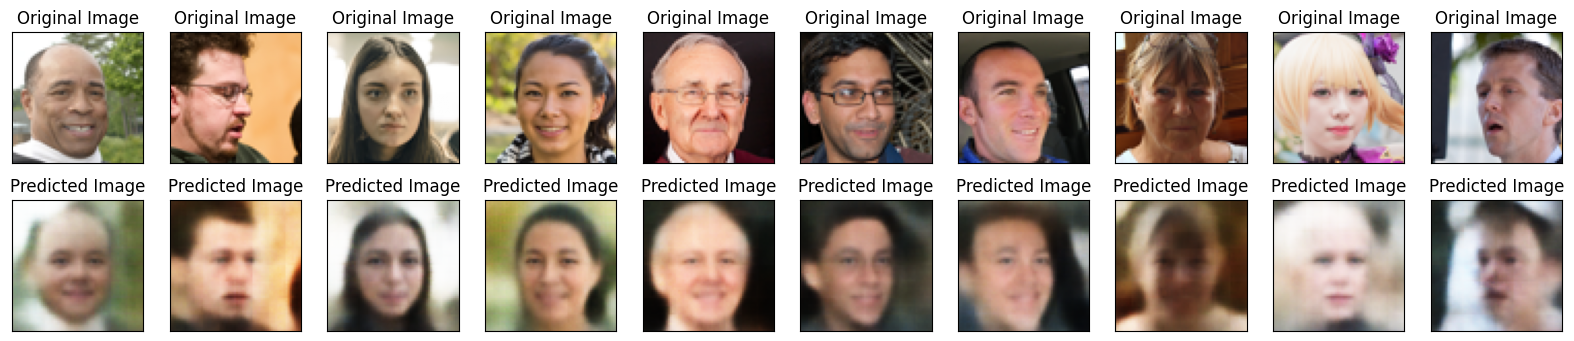

In [25]:
n = 10  ## how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("Original Image")
    plt.imshow(x_test[i].reshape(H, W, C))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title("Predicted Image")
    plt.imshow(test_pred_y[i].reshape(H, W, C))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
history = autoencoder.history.history
plt.plot(history['val_loss'],label="test")
plt.plot(history['loss'],label="training")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graph.png')

KeyError: 'val_loss'